# EDSA Apple Prices Challenge

Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

With this context, EDSA is challenging you to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

## Data Overview

This dataset consists of over 60 000 sales made by [Durban Fresh Produce Market](http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx). In this notebook, we use this data to predict the average price per kilogram of Golden Delicious Apples.

Below is a brief description for each data field:
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

<h1>Table of Contents</h1>
<ul>
    <li><a href="#eda">Exploratiory Data Analysis</a></li>
    <li><a href="#modeldevelopment">Model Development</a></li>
    <li><a href="#modelevaluation">Model Selection</a></li>
    <li><a href="#modelselection">Model Selection</a></li>
</ul>

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Visualisations
#import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline

# Other
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle

<h1 id="edsa"> Exploratory Data Analysis   </h1>
<p>

## Basic Analysis

#### We want to investigate what data we obtained from the Durban Fresh Produce Market and how much sales they made during the year 2020.


In [2]:
# import the data
train = pd.read_csv('df-train_set.csv')
test = pd.read_csv('df-test_set.csv')

In [3]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
train.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

In [5]:
train.columns = map(str.lower, train.columns) #for accessability and consistency in analysing the data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   province          64376 non-null  object 
 1   container         64376 non-null  object 
 2   size_grade        64376 non-null  object 
 3   weight_kg         64376 non-null  float64
 4   commodities       64376 non-null  object 
 5   date              64376 non-null  object 
 6   low_price         64376 non-null  float64
 7   high_price        64376 non-null  float64
 8   sales_total       64376 non-null  float64
 9   total_qty_sold    64376 non-null  int64  
 10  total_kg_sold     64376 non-null  float64
 11  stock_on_hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


In [7]:
train.shape

(64376, 13)

The data shows that there are 13 feautures which have 64376 observations which were recorded in the year 2020 and Durban Fresh Market. There are 5 ordinal features with 8 quantitative features of which 2 are discrete features. 

We are investigating the suppliers that Produce Market has.

In [8]:
commodities=list(train.commodities.unique())
print(commodities)

['APPLE GRANNY SMITH', 'APPLE GOLDEN DELICIOUS', 'AVOCADO PINKERTON', 'TOMATOES-LONG LIFE', 'POTATO SIFRA (WASHED)', 'NOVAS', 'SATSUMAS', 'GARLIC IMPORTED', 'LEMON', 'CUCUMBERS ENGLISH', 'BANANA', 'TOMATOES OTHER', 'APPLE BRAEBURN', 'GRAPE OTHER WHITE', 'BANANA FINGERS SINGLE', 'ONIONS BROWN', 'POTATO PANAMERA', 'POTATO (WASHED) MONDIAL', 'GRAPE MIDNIGHT BEAUTY', 'PEACH OTHER', 'BUTTERNUTS', 'POTATO (WASHED) UP-TO-DATE', 'PEAR PACKHAMS TRIUMPH', 'APPLE GALA', 'SWEET POTATOES ORANGE', 'SWEET POTATOES RED', 'AUTUMN CRUNCH', 'ONIONS MILD', 'ORANGE NAVELS', 'PEAR FORELLE', 'WATERMELON', 'TOMATOES SALADETTE', 'AVOCADO RYAN', 'NADORCOTT', 'POTATO LANORMA (WASHED)', 'ORANGE OTHER', 'APPLE FUJI', 'GRAPEFRUIT STAR RUBY', 'APPLE ROYAL GALA', 'APPLE OTHER', 'PEACH SUMMER SUN', 'TOMATOES JAM', 'BANANA LOWER GRADE (OTHER)', 'GRAPE CRIMSON SEEDLESS', 'APPLE CRIPPS PINK', 'ORANGE VALENCIAS', 'PEACH SPRINGCREST', 'GARLIC PURPLE', 'ONIONS WHITE', 'NECTARINE OTHER', 'NECTARINE AUGUST RED', 'ONIONS RED',

In [9]:
# The number of suppliers 
print(f'The number of supplier that Durban Fresh Produce Market is {len(commodities)}')

The number of supplier that Durban Fresh Produce Market is 270


The Durban Fresh Produce Market has 270 suppliers as indicated by the commodities column. We are only required to predict price for supplier which is Golden Delicious Apple which under Commodities is written as **APPLE GOLDEN DELICIOUS**. We are only going to focus the supplier mentioned from the above.

### Filtering the data to what we need to look at: Golden Delicious Apples

In [10]:
#filtering the data to what we need to look at: Golden Delicious Apples
train = train[train['commodities'] == 'APPLE GOLDEN DELICIOUS']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


In [11]:
train.columns

Index(['province', 'container', 'size_grade', 'weight_kg', 'commodities',
       'date', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg'],
      dtype='object')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   province          1952 non-null   object 
 1   container         1952 non-null   object 
 2   size_grade        1952 non-null   object 
 3   weight_kg         1952 non-null   float64
 4   commodities       1952 non-null   object 
 5   date              1952 non-null   object 
 6   low_price         1952 non-null   float64
 7   high_price        1952 non-null   float64
 8   sales_total       1952 non-null   float64
 9   total_qty_sold    1952 non-null   int64  
 10  total_kg_sold     1952 non-null   float64
 11  stock_on_hand     1952 non-null   int64  
 12  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 213.5+ KB


In [13]:
train.shape

(1952, 13)

The data shows that there are 13 feautures which have 1952 observations which were recorded in the year 2020 and Durban Fresh Market. There are 3 ordinal features namely Province,container and size_grade. There is also 8 numerical features which are continuous

### Basic Analysis of new dataset 

In [14]:
train.isnull().sum()

province            0
container           0
size_grade          0
weight_kg           0
commodities         0
date                0
low_price           0
high_price          0
sales_total         0
total_qty_sold      0
total_kg_sold       0
stock_on_hand       0
avg_price_per_kg    0
dtype: int64

The data has no null/ missing data thus there is no need for data cleaning at the moment.

### Setting the columns to appropriate data types 


Some of the features such as Date are in an incorrect format or their datatype will make analysis and even prediction more difficult to do. Thus, setting the datatypes is a critical step.

In [15]:
#Set datetime data 
train["date"] = pd.to_datetime(train["date"],format="%Y.%m.%d")

#Set categorical data
train['province'] = train['province'].astype('category')
train['container'] = train['container'].astype('category')
train['size_grade'] = train['size_grade'].astype('category')

The improved dataset with appropriate data types as per feature characteristic:

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   province          1952 non-null   category      
 1   container         1952 non-null   category      
 2   size_grade        1952 non-null   category      
 3   weight_kg         1952 non-null   float64       
 4   commodities       1952 non-null   object        
 5   date              1952 non-null   datetime64[ns]
 6   low_price         1952 non-null   float64       
 7   high_price        1952 non-null   float64       
 8   sales_total       1952 non-null   float64       
 9   total_qty_sold    1952 non-null   int64         
 10  total_kg_sold     1952 non-null   float64       
 11  stock_on_hand     1952 non-null   int64         
 12  avg_price_per_kg  1952 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(6), int64(2), object(1)
memory usa

### Univariate Analysis: Non-Graphical

### For the numerical data:

In [17]:
#Descriptive Statistics
train.describe()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


From observing the numerical data there are many errors in the data :
* The mean of the features is quite distinct from the median which indicates there are outliers present

To check the distribution of the data: 

In [18]:
#checking distrubution of the data
train.skew()

weight_kg           3.328254
low_price           4.222672
high_price          3.828819
sales_total         4.250317
total_qty_sold      4.445169
total_kg_sold       5.529586
stock_on_hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

The skewness of the data tells us how each numerical is distributed and how symmetrical it is. It is observed that:
 * All of our features except for the average price per kg are extremely positive skewed indicate by the values being 
   greater than 1.
 * The Average price per kg feature which is our target variable is fairly symetrical the skew value of 0.082452 is between -0.5 and 0.5

In [19]:
#checking for outliers in the data
train.kurt()

weight_kg            9.109698
low_price           17.073369
high_price          13.630768
sales_total         24.200524
total_qty_sold      32.338123
total_kg_sold       45.153801
stock_on_hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

From the above we can see that there is a high number of outliers present in our observations as we have observed high kurtosis(**>3**) for all the features except for the target feature,avg_price_per_kg with kurtosis value 1.042921. 

### For Categorical Data:

In [20]:
train.describe(include=['category'])

,province,container,size_grade
count,1952,1952,1952
unique,7,11,10
top,CAPE,M4183,1S
freq,1045,588,532


The categorical data description shows us the mode which is indicated by top and the frequncy of data. The data show that most apples came from Cape province which had the size_grad of 1S and most of the stored in the container: M4183.

### Univariate Analysis: Graphical

In [21]:
sns.set_theme(style="whitegrid")

#### Numerical Features:

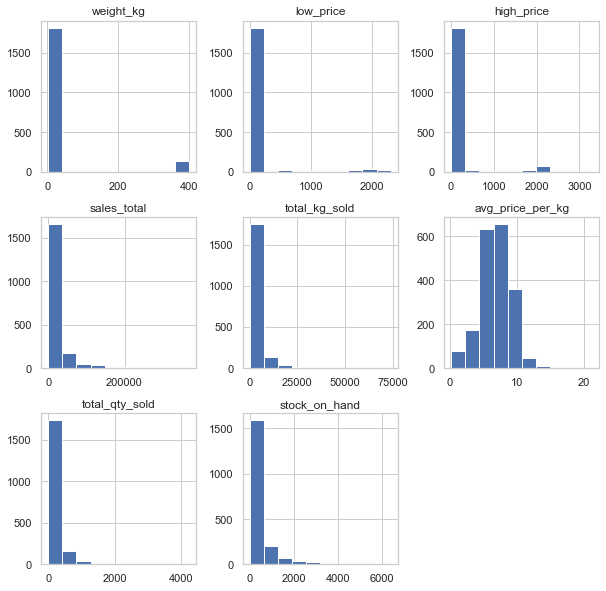

In [22]:
numerical_features =list(train.select_dtypes(include=['float64']).columns)
numerical_features = numerical_features +list(train.select_dtypes(include=['int64']).columns)

train[numerical_features].hist()
plt.gcf().set_size_inches(10, 10)

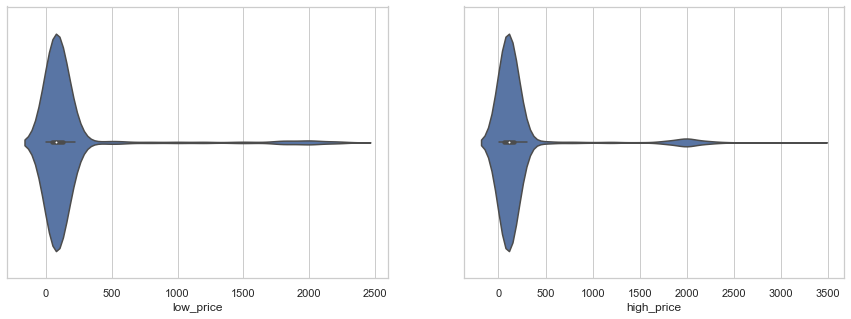

In [23]:
fig, ax =plt.subplots(1,2)
sns.violinplot(x = 'low_price', data = train,ax=ax[0])
sns.violinplot(x = 'high_price', data = train,ax=ax[1])
#sns.violinplot(x = 'avg_price_per_kg',data = train, ax=ax[2])
plt.gcf().set_size_inches(15, 5)


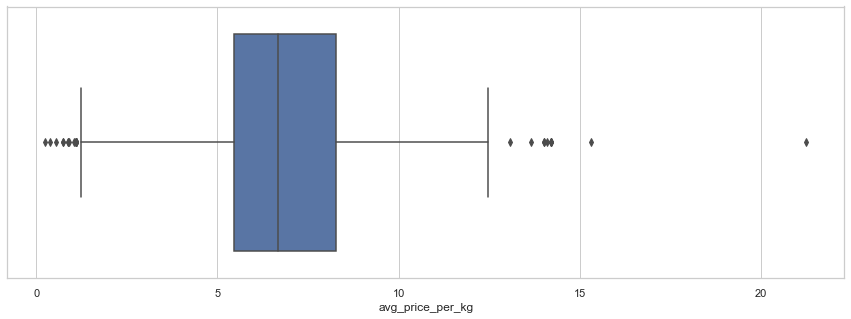

In [24]:
sns.boxplot(x = 'avg_price_per_kg', data = train)
plt.gcf().set_size_inches(15, 5)

#### Categorical Features:

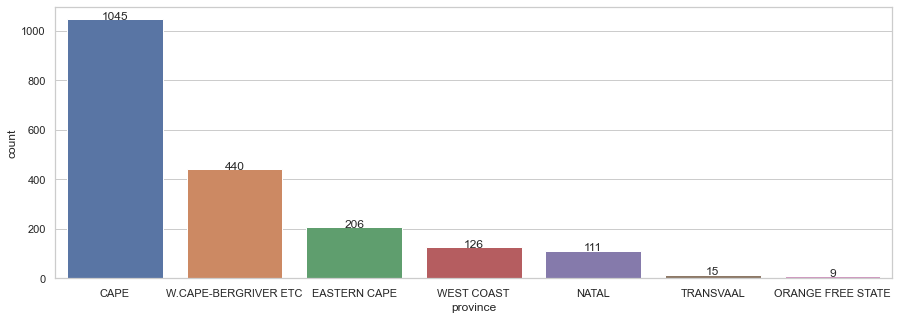

In [25]:
graph = sns.countplot(x = 'province',data = train,order = train['province'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.gcf().set_size_inches(15, 5)

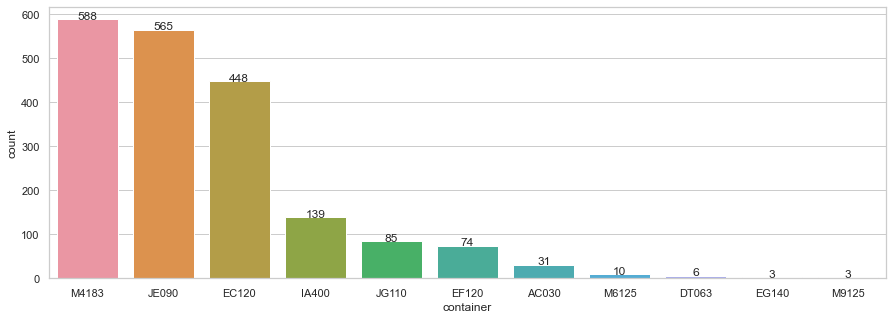

In [26]:
graph = sns.countplot(x = 'container', data = train,order = train['container'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)


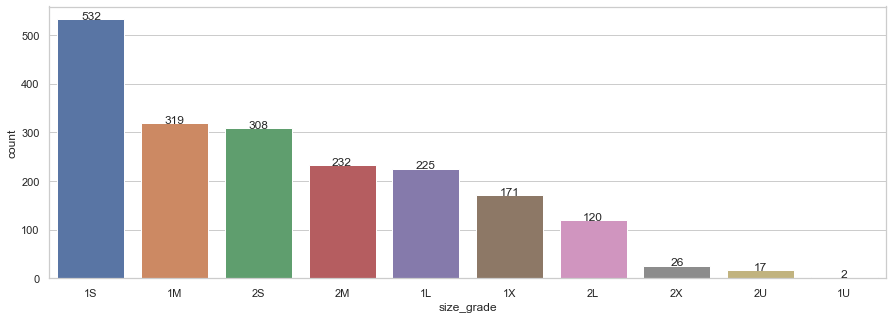

In [27]:
graph = sns.countplot(x = 'size_grade', data = train,order = train['size_grade'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)

## Dealing with outliers:

In [28]:
shape_before = train.shape[0]

In [29]:
train_numerical = train.loc[:, 'weight_kg':'avg_price_per_kg'].drop(columns=['commodities','date'])
train = train[(np.abs(stats.zscore(train_numerical)) < 3).all(axis=1)]

In [30]:
print("Number of ouliers removed:", shape_before - train.shape[0])

Number of ouliers removed: 239


## After outliers:

### Univariate Analysis: Non-Graphical

In [31]:
train.shape

(1713, 13)

In [32]:
train.describe()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
count,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000
mean,12.807998,84.650321,103.267951,13291.842966,142.383538,1839.110333,333.629889,6.926585
std,4.066947,45.261207,52.629480,19938.188874,191.650689,2601.352286,474.022040,2.085047
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.550000
25%,9.000000,50.000000,60.000000,1140.000000,15.000000,180.000000,12.000000,5.560000
50%,12.000000,72.000000,96.000000,4840.000000,65.000000,768.600000,144.000000,6.770000
75%,18.300000,120.000000,150.000000,16590.000000,190.000000,2403.000000,443.000000,8.350000
max,18.300000,220.000000,260.000000,132150.000000,1087.000000,19178.400000,2555.000000,13.070000


In [33]:
train.skew()

weight_kg           0.250577
low_price           0.678135
high_price          0.424259
sales_total         2.518151
total_qty_sold      2.075943
total_kg_sold       2.280170
stock_on_hand       2.176992
avg_price_per_kg   -0.124066
dtype: float64

In [34]:
train.kurt()

weight_kg          -1.068424
low_price          -0.271852
high_price         -0.827616
sales_total         7.429437
total_qty_sold      4.397705
total_kg_sold       5.872929
stock_on_hand       4.927424
avg_price_per_kg   -0.067884
dtype: float64

### For Categorical Data:

In [35]:
train.describe(include=['category'])

,province,container,size_grade
count,1713,1713,1713
unique,7,10,10
top,CAPE,JE090,1S
freq,868,560,356


### Univariate Analysis: Graphical

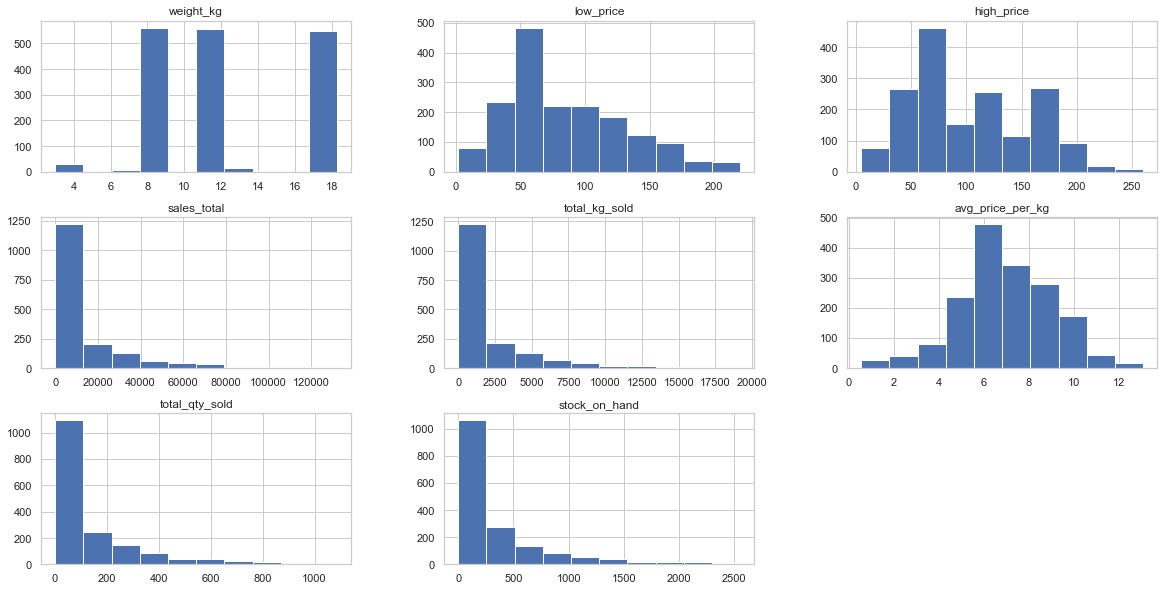

In [36]:
numerical_features =list(train.select_dtypes(include=['float64']).columns)
numerical_features = numerical_features +list(train.select_dtypes(include=['int64']).columns)

train[numerical_features].hist()
plt.gcf().set_size_inches(20, 10)

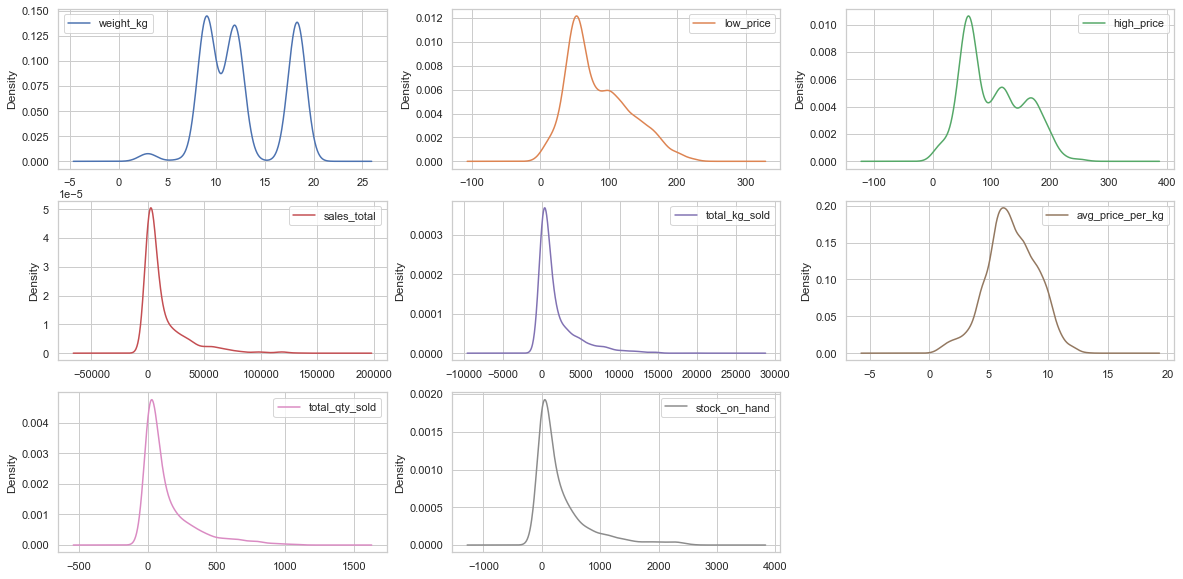

In [37]:
train[numerical_features].plot(kind='density', subplots=True, layout=(3, 3), sharex=False)

plt.gcf().set_size_inches(20, 10)

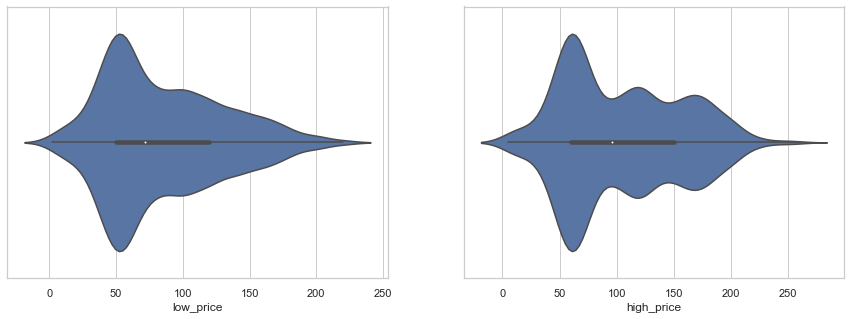

In [38]:
fig, ax =plt.subplots(1,2)
sns.violinplot(x = 'low_price', data = train,ax=ax[0])
sns.violinplot(x = 'high_price', data = train,ax=ax[1])

plt.gcf().set_size_inches(15, 5)

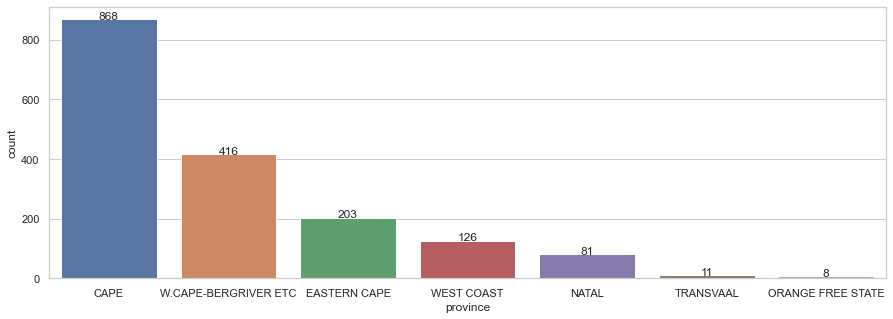

In [64]:
graph = sns.countplot(x = 'province',data = train,order = train['province'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.gcf().set_size_inches(15, 5)

posx and posy should be finite values
posx and posy should be finite values


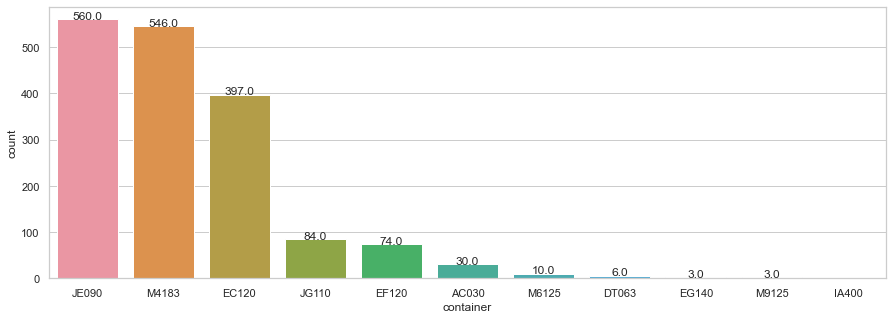

In [65]:
graph = sns.countplot(x = 'container', data = train,order = train['container'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)

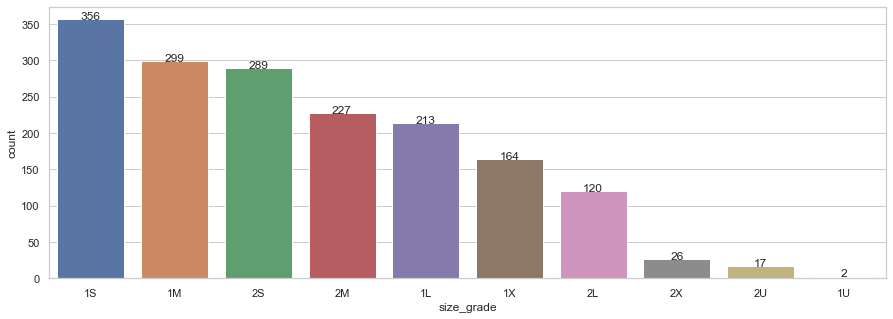

In [66]:
graph = sns.countplot(x = 'size_grade', data = train,order = train['size_grade'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)

### Target Feature Analysis : Average price per kg

The target feature is the average price per kg of the Golden Delicous Apples
 * non graphical approach
 * graphical analysis
 
 
 

In [39]:
train.avg_price_per_kg.describe()

count    1713.000000
mean        6.926585
std         2.085047
min         0.550000
25%         5.560000
50%         6.770000
75%         8.350000
max        13.070000
Name: avg_price_per_kg, dtype: float64

In [40]:
train.avg_price_per_kg.mode()

0    6.67
dtype: float64

In [41]:
train.avg_price_per_kg.skew()

-0.12406596852535741

In [42]:
train.avg_price_per_kg.kurt()

-0.06788406525881863

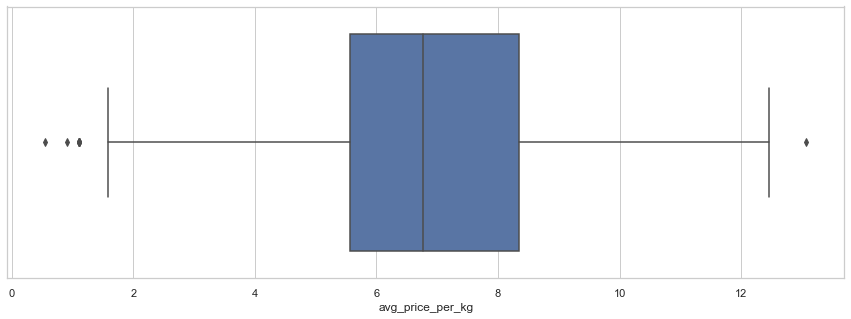

In [43]:
sns.boxplot(x = 'avg_price_per_kg', data = train)
plt.gcf().set_size_inches(15, 5)

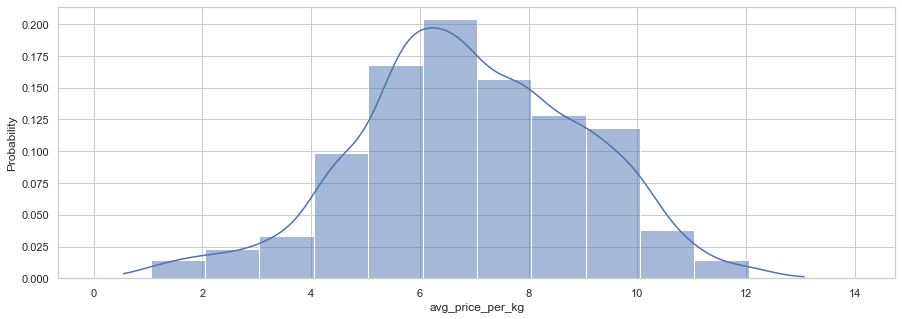

In [44]:
sns.histplot(data=train, x="avg_price_per_kg", stat="probability", discrete=True, kde = True)

plt.gcf().set_size_inches(15, 5)

### Multivariate Analysis: Non-Graphical 

In [45]:
train.corr()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
weight_kg,1.000000,0.793893,0.882803,0.295567,0.019849,0.237463,0.107011,0.492860
low_price,0.793893,1.000000,0.872611,0.200786,-0.062253,0.097729,0.025886,0.815544
high_price,0.882803,0.872611,1.000000,0.371799,0.085026,0.274045,0.160419,0.763701
sales_total,0.295567,0.200786,0.371799,1.000000,0.861513,0.967201,0.231615,0.228662
total_qty_sold,0.019849,-0.062253,0.085026,0.861513,1.000000,0.932626,0.220947,0.011603
total_kg_sold,0.237463,0.097729,0.274045,0.967201,0.932626,1.000000,0.233279,0.102003
stock_on_hand,0.107011,0.025886,0.160419,0.231615,0.220947,0.233279,1.000000,0.074820
avg_price_per_kg,0.492860,0.815544,0.763701,0.228662,0.011603,0.102003,0.074820,1.000000


### Multivariate Analysis: Graphical

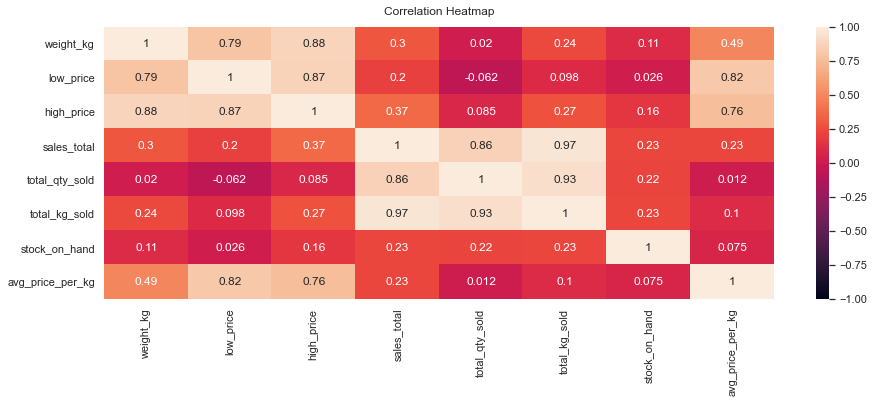

In [46]:
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.gcf().set_size_inches(15, 5)

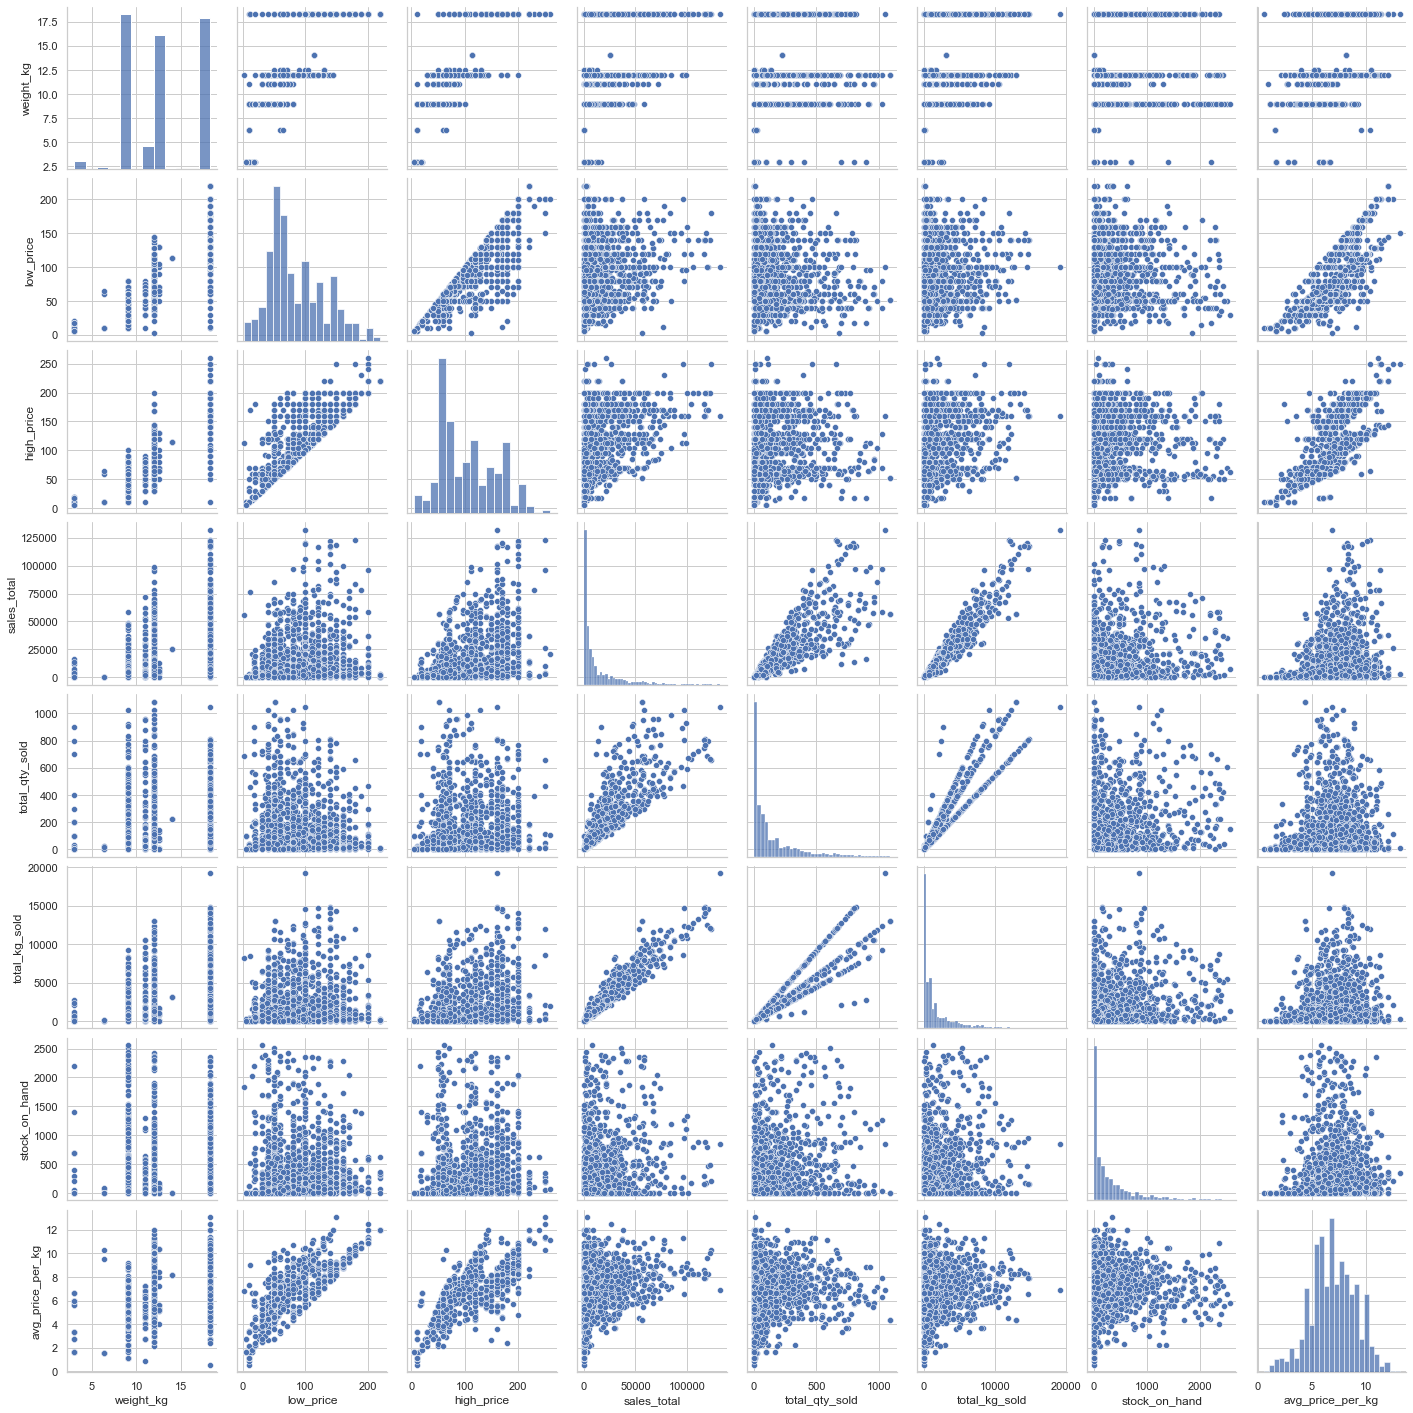

In [57]:
sns.pairplot(train)

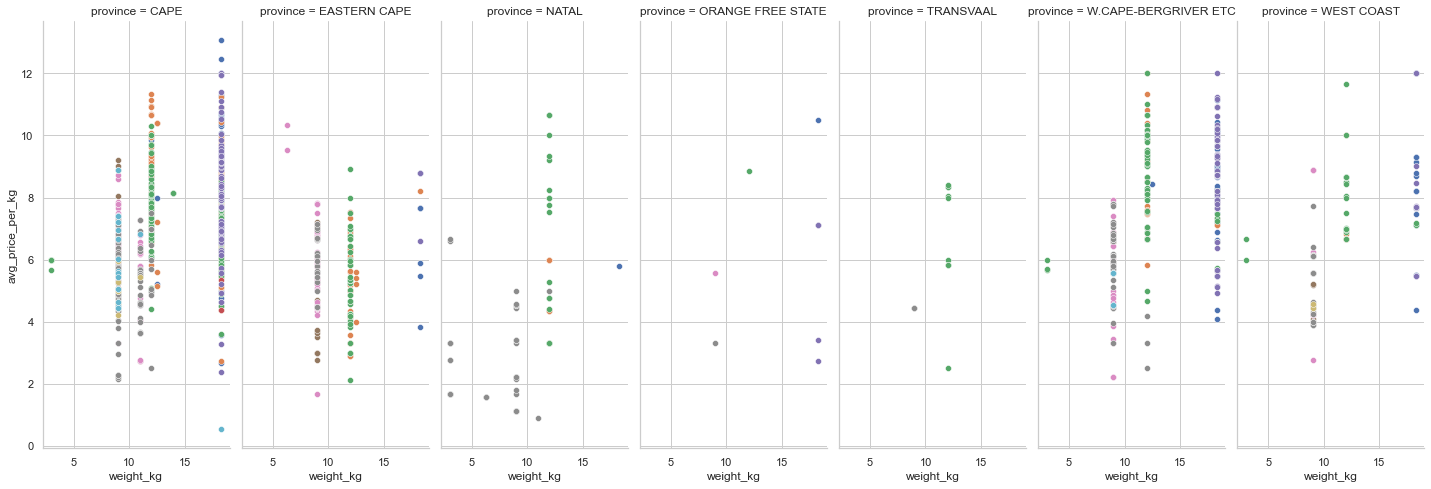

In [60]:
g = sns.FacetGrid(train, col="province",hue = 'size_grade')
g.map(sns.scatterplot, "weight_kg", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(20, 9)

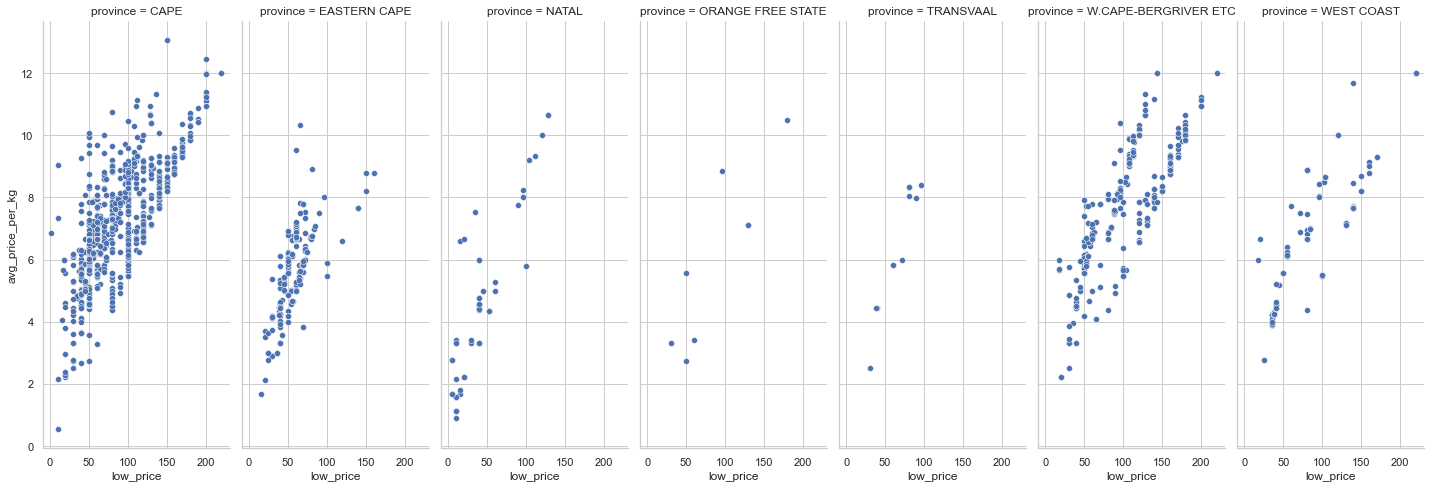

In [61]:
g = sns.FacetGrid(train, col="province")
g.map(sns.scatterplot, "low_price", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(20, 9)

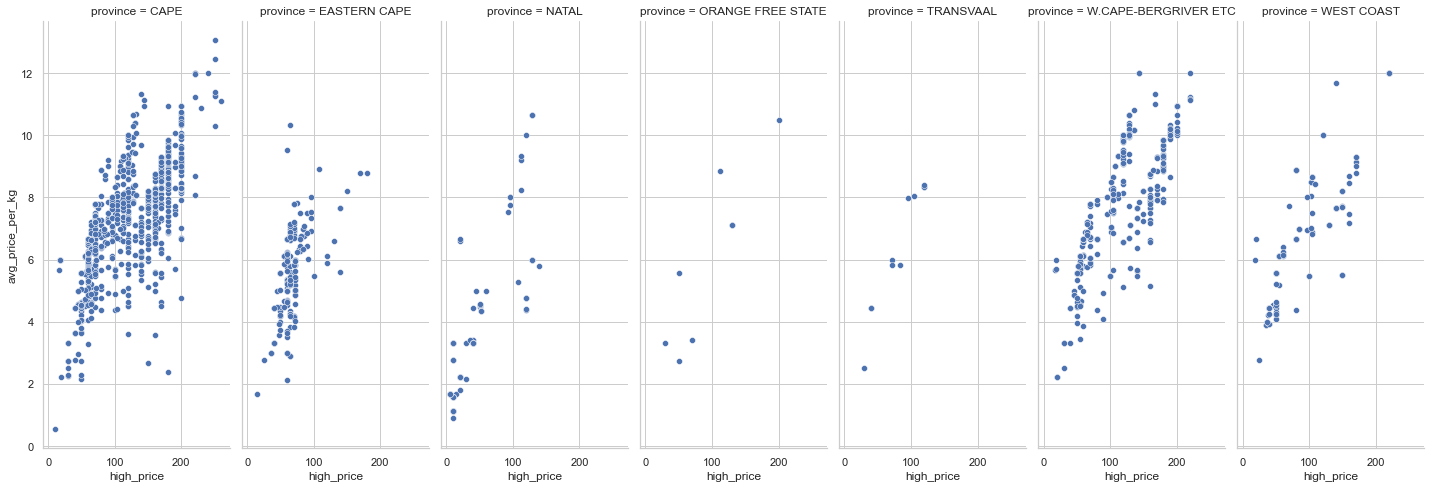

In [62]:
g = sns.FacetGrid(train, col="province")
g.map(sns.scatterplot, "high_price", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(20, 9)

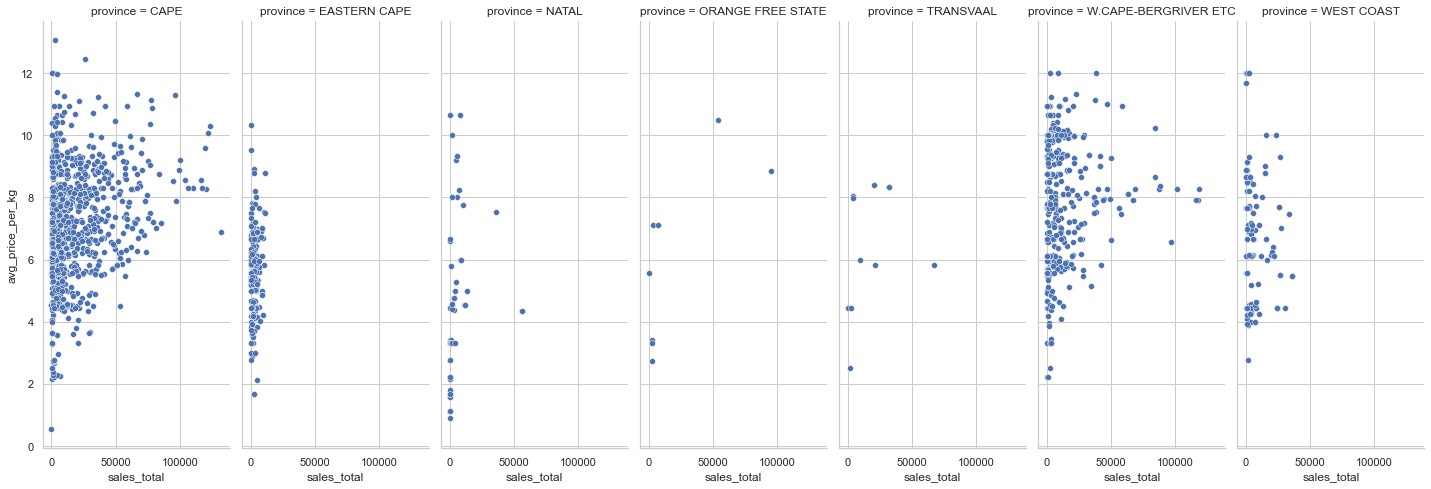

In [63]:
g = sns.FacetGrid(train, col="province")
g.map(sns.scatterplot, "sales_total", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(20, 9)

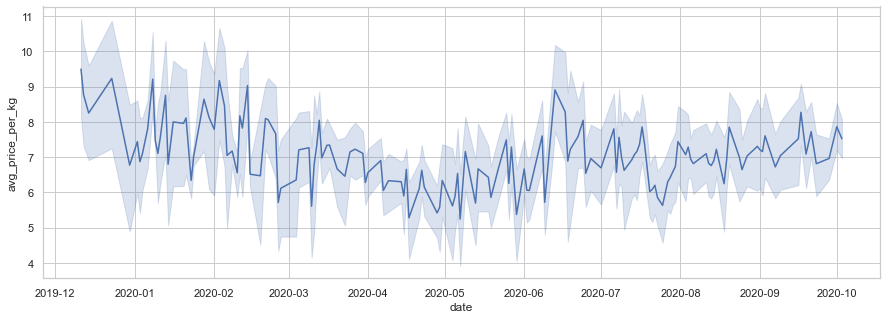

In [48]:
sns.lineplot(x="date", y="avg_price_per_kg",
             data=train)
plt.gcf().set_size_inches(15, 5)

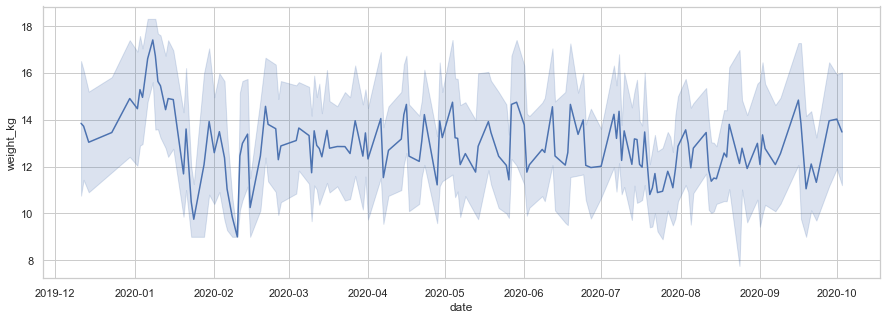

In [53]:
sns.lineplot(x="date", y="weight_kg",
             data=train)
plt.gcf().set_size_inches(15, 5)

### Grouping Data 

### Correlation and Causation

### ANOVA 

<h1 id="modeldevelopment">Model Development  </h1>
<p>

<h1 id="modelevaluation">Model Evaluation  </h1>
<p>

<h1 id="modelselection">Model Selection, Overfitting and Underfitting  </h1>
<p>

# Submission